In [3]:
import numpy as np
import pandas as pd
import os
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools
import time

os.chdir ('C:\\Users\\syedd\\Downloads')

C:\Users\syedd\AppData\Local\Temp\ipykernel_12104\3327821485.py:4: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [4]:
os.getcwd()

'C:\\Users\\syedd\\Downloads'

In [5]:
columns=['Subject_id','Jitter(local)','Jitter(local,absolute)','Jitter(rap)','Jitter(ppq5)',
        'Jitter(ddp)','Shimmer (local)','Shimmer (local, dB)', 'Shimmer (apq3)', 'Shimmer (apq5)', 'Shimmer (apq11)', 'Shimmer (dda)'
         ,'AC', 'NTH', 'HTN','Median pitch', 'Mean pitch', 'Standard deviation', 'Minimum pitch', 'Maximum pitch',
        'Number of pulses', 'Number of periods', 'Mean period', 'Standard deviation of period',
        'Fraction of locally unvoiced frames', 'Number of voice breaks', 'Degree of voice breaks',
        'UPDRS score','class information']
Parkinson_Data=pd.read_csv("Assignment2_2023_data.txt",names=columns,header=None)
Parkinson_Data=Parkinson_Data.drop('Subject_id',axis=1)
Parkinson_Data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Jitter(local)                        1040 non-null   float64
 1   Jitter(local,absolute)               1040 non-null   float64
 2   Jitter(rap)                          1040 non-null   float64
 3   Jitter(ppq5)                         1040 non-null   float64
 4   Jitter(ddp)                          1040 non-null   float64
 5   Shimmer (local)                      1040 non-null   float64
 6   Shimmer (local, dB)                  1040 non-null   float64
 7   Shimmer (apq3)                       1040 non-null   float64
 8   Shimmer (apq5)                       1040 non-null   float64
 9   Shimmer (apq11)                      1040 non-null   float64
 10  Shimmer (dda)                        1040 non-null   float64
 11  AC                            

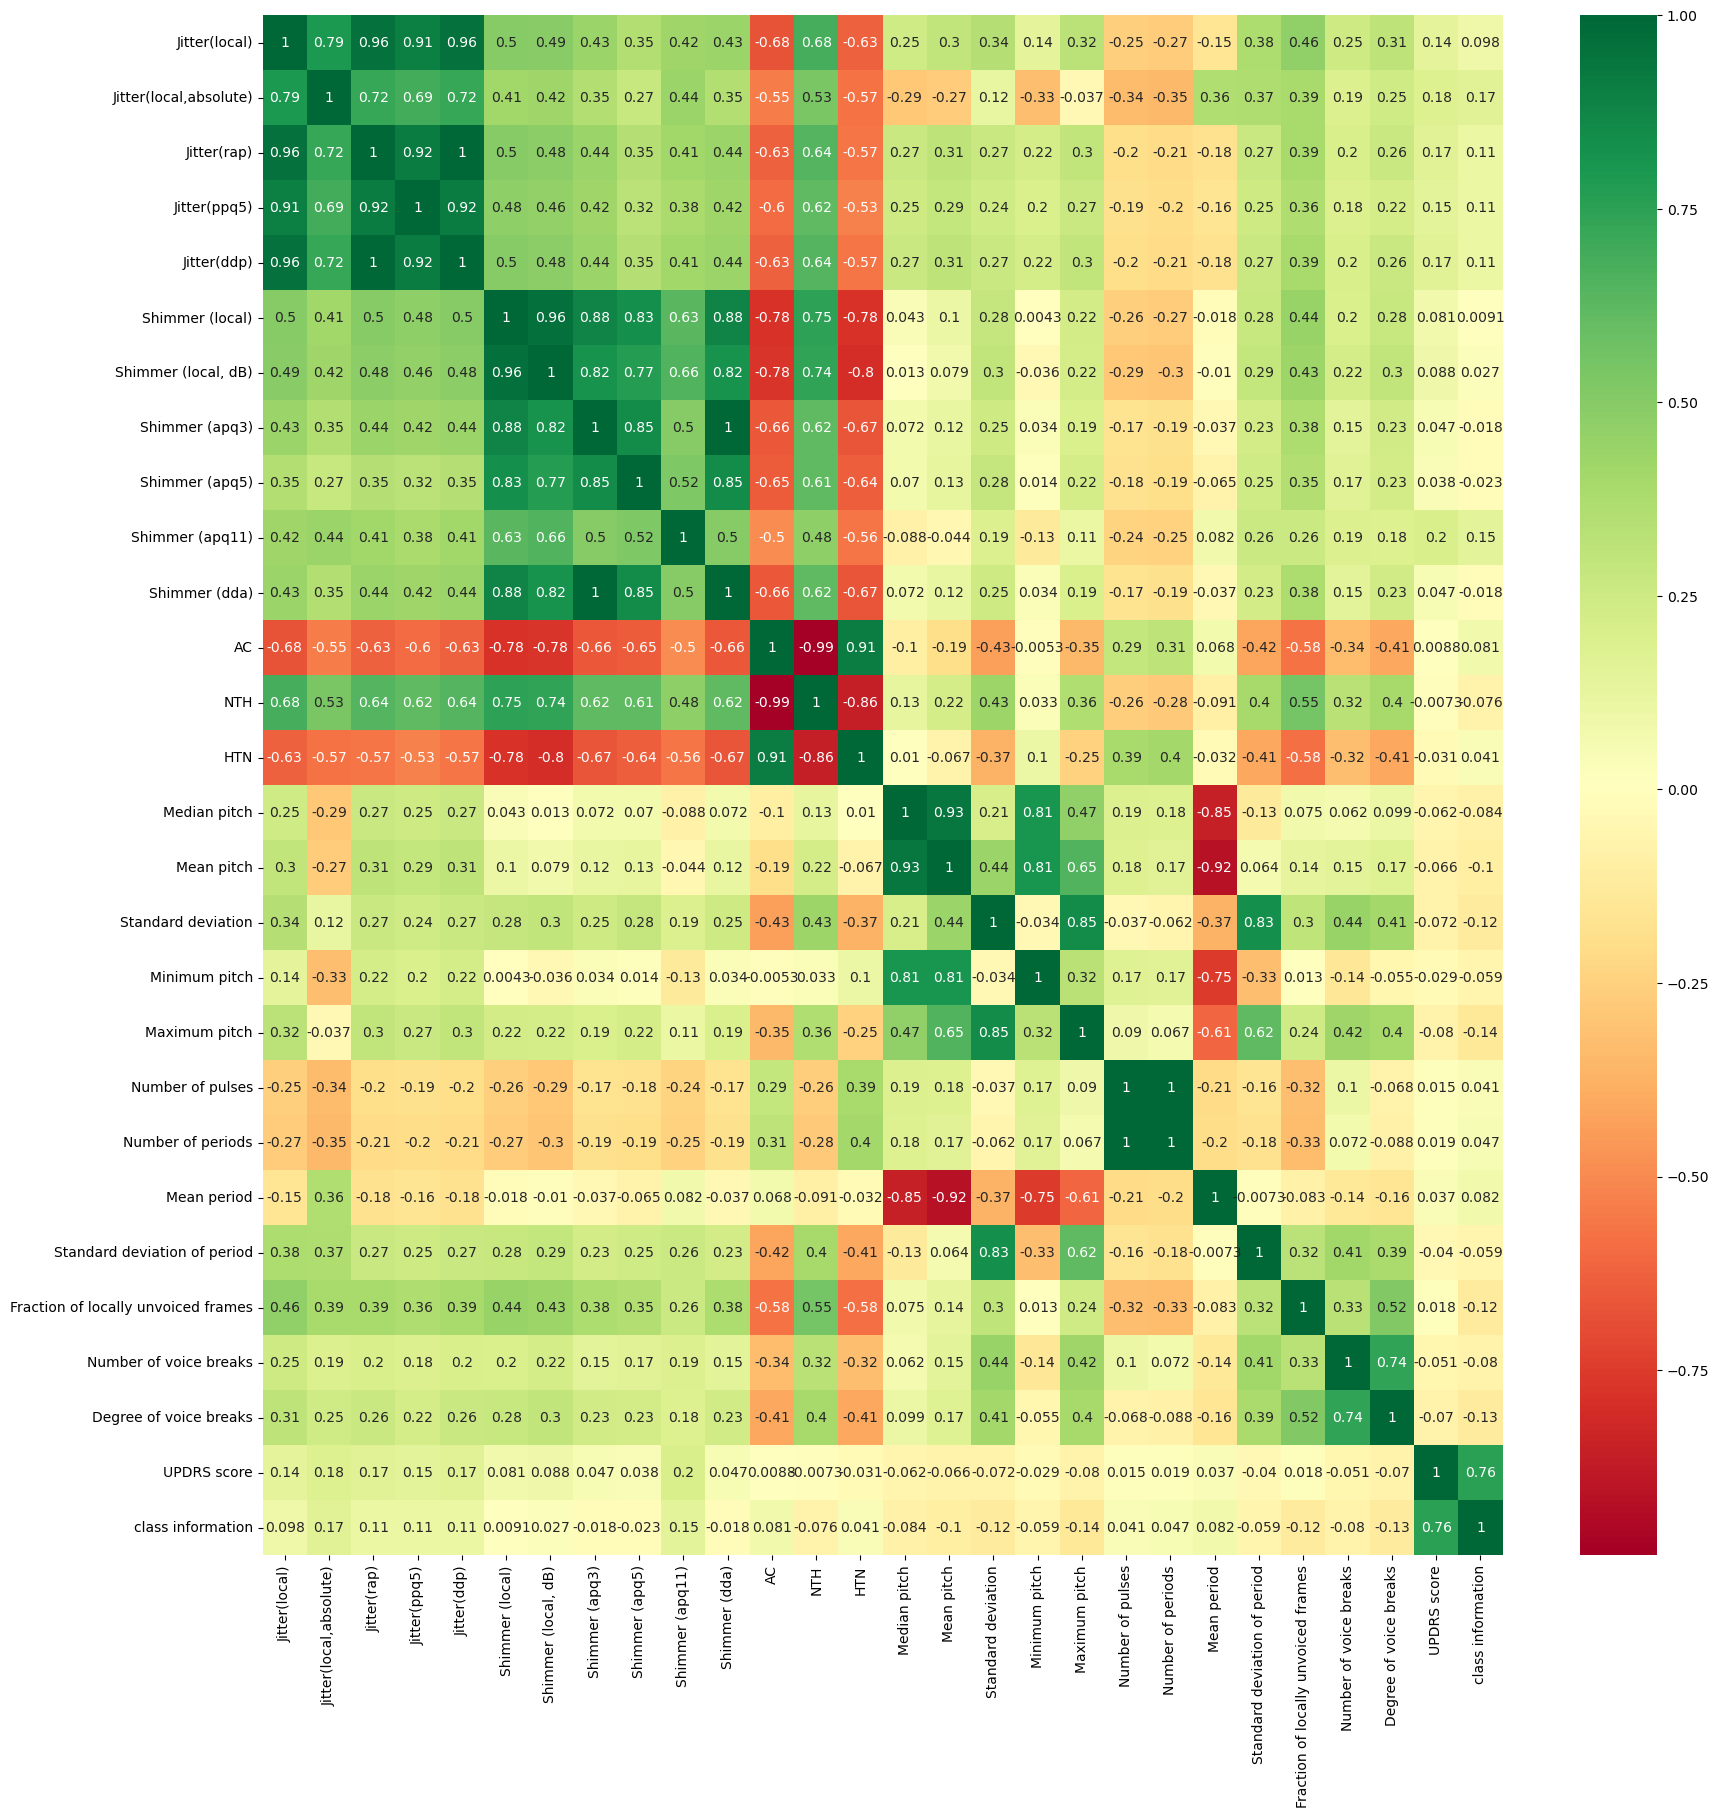

In [6]:
#feature selection
##Filter method
##correlation analytsis since numerical input and result is in input;
# run correlation matrix and plot
corrmat = Parkinson_Data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(Parkinson_Data[top_corr_features].corr(),annot=True,cmap="RdYlGn")
##In this feature selection. ID and class information need to remove since need to check score
X=Parkinson_Data.drop('UPDRS score',axis=1)  
Y=Parkinson_Data['UPDRS score'] #target data




In [7]:
#feature selection
##unvariate selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X=Parkinson_Data.drop('UPDRS score',axis=1) 
Y=Parkinson_Data['UPDRS score'] #target data

##Apply selectKbest class to extract all score for best features
bestfeatures = SelectKBest(score_func=chi2, k=11)
fit = bestfeatures.fit(X,Y)
Datascores =pd.DataFrame(fit.scores_)
DataColumns =pd.DataFrame(X.columns)
Parkinsonscore=pd.concat([DataColumns,Datascores],axis=1)
Parkinsonscore.columns=["Specs","Score"]

In [8]:
print(Parkinsonscore.nlargest(11,"Score"))

                                  Specs        Score
20                    Number of periods  8973.072021
19                     Number of pulses  8473.153445
18                        Maximum pitch  4151.806007
16                   Standard deviation  3457.264591
14                         Median pitch  3368.703523
15                           Mean pitch  2987.568298
17                        Minimum pitch  2449.519851
23  Fraction of locally unvoiced frames  1579.525238
25               Degree of voice breaks   647.788016
10                        Shimmer (dda)   534.279155
26                    class information   520.000000


In [ ]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(Y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - Y) ** 2).sum()
    return {"model":regr, "RSS":RSS}
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model
# Could take quite awhile to complete...

models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 27 models on 1 predictors in 0.53594970703125 seconds.
Processed 351 models on 2 predictors in 0.5971040725708008 seconds.
Processed 2925 models on 3 predictors in 4.6720452308654785 seconds.
Processed 17550 models on 4 predictors in 31.730098485946655 seconds.
Processed 80730 models on 5 predictors in 248.03647780418396 seconds.


In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

#feature selection
##feature Importance
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,Y)
#to see feature importaances of tree based classifiers
print(model.feature_importances_)
#plot graph of feature importances
feat_importances = pd.Series(model.feature_importances_,index=X.columns)
feat_importances.nlargest(7).plot(kind="barh")
plt.show()

In [ ]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(Y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - Y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [ ]:
#forward selection
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")


In [ ]:
#backward selection
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time", (toc-tic), "seconds.")

In [ ]:
plt.plot(models_bwd["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot( models_bwd["RSS"])
plt.plot(models_fwd["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot( models_fwd["RSS"])

In [ ]:
models_fwd

In [ ]:
print("-----------------")
print("Forward Selection:")
print("-----------------")
print(models_fwd.loc[15,"model"].params)
print(models_fwd.loc[15,"model"].summary())
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[9,"model"].params)
print(models_bwd.loc[9,"model"].summary())

In [ ]:
#feature classfication ##number to numerical
Correlation=Parkinson_Data.corr(method='pearson')
print(Correlation.loc["UPDRS score"])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#Model
X=Parkinson_Data.drop("UPDRS score",axis=1) 
Y=Parkinson_Data['UPDRS score'] #target data
X_train,X_test,y_train,y_test= train_test_split(X,Y,test_size=0.2)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#filter method
X_FILTER=Parkinson_Data[['Jitter(local,absolute)','Jitter(rap)','Jitter(ppq5)',
                        'Jitter(ddp)', 'Shimmer (apq11)','class information']]
X_Filter_train,X_Filter_test,y_train,y_test= train_test_split(X_FILTER,Y,test_size=0.2)
X_train_Filter_scaled = scaler.fit_transform(X_Filter_train)
X_test_Filter_scaled = scaler.transform(X_Filter_test)
#wrapper method(Backward and forward)

##Forward
X_Fwd=Parkinson_Data[['Fraction of locally unvoiced frames','Mean period','Shimmer (apq11)','NTH','Degree of voice breaks',
                     'Jitter(ddp)','class information','Jitter(local)','Jitter(rap)','Median pitch','AC',
                     'Mean pitch','Standard deviation of period','Standard deviation','Number of pulses']]
X_Fwd_train,X_Fwd_test,y_train,y_test= train_test_split(X_Fwd,Y,test_size=0.2)
X_train_Fwd_scaled = scaler.fit_transform(X_Fwd_train)
X_test_Fwd_scaled = scaler.transform(X_Fwd_test)
##Backward
X_Bwd=Parkinson_Data[['Jitter(local)','Jitter(ddp)','Mean pitch','Mean period','Fraction of locally unvoiced frames','class information',
                     'Shimmer (dda)','AC']]
X_Bwd_train,X_Bwd_test,y_train,y_test= train_test_split(X_Bwd,Y,test_size=0.2)
X_train_Bwd_scaled = scaler.fit_transform(X_Bwd_train)
X_test_Bwd_scaled = scaler.transform(X_Bwd_test)

#Embedded method
##unvariate selection
X_UNVARIATE = Parkinson_Data[["Number of periods","Number of pulses","Maximum pitch","Standard deviation",
                             "Median pitch","Mean pitch","Minimum pitch","Fraction of locally unvoiced frames",
                             "Degree of voice breaks",'Shimmer (dda)',"class information"]]
X_Unvariate_train,X_Unvariate_test,y_train,y_test= train_test_split(X_UNVARIATE,Y,test_size=0.2)
X_train_Unvariate_scaled = scaler.fit_transform(X_Unvariate_train)
X_test_Unvariate_scaled = scaler.transform(X_Unvariate_test)

In [ ]:
Y

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
scores = []

for i in range(40,150,2):
    model = RandomForestClassifier(n_estimators=i, bootstrap=True,)
    
    model.fit(X_train,y_train)
    
    scores.append(model.score(X_test,y_test))

plt.plot(range(40,150,2), scores)
# find the n_estimator value for which score is highest
high_score_index = scores.index(max(scores))
estimators = np.arange(40,150,2)
n_est = estimators[high_score_index]


In [ ]:
n_est

In [ ]:
#Model Training and Evalution
model= RandomForestClassifier(random_state=42,n_estimators=n_est)
model.fit(X_train_scaled, y_train)
#make predictions
yhat=model.predict(X_test_scaled)
#evaluate predictionc
acc = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % acc)
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)
test_error_rate = np.mean(yhat != y_test)
print('Test error rate:', test_error_rate)
print(classification_report(y_test,yhat))

In [ ]:
#Model Training and Evalution
model_filter= RandomForestClassifier(random_state=42,n_estimators=n_est)
model_filter.fit(X_train_Filter_scaled, y_train)
#make predictions
ypred=model_filter.predict(X_test_Filter_scaled)
#evaluate predictionc
acc = accuracy_score(y_test, ypred)
print('Accuracy: %.3f' % acc)
mae = mean_absolute_error(y_test, ypred)
print('MAE: %.3f' % mae)
test_error_rate = np.mean(ypred != y_test)
print('Test error rate:', test_error_rate)
print(classification_report(y_test,ypred))

In [ ]:
#Model Training and Evalution
model_Fwd= RandomForestClassifier(random_state=42,n_estimators=n_est)
model_Fwd.fit(X_train_Fwd_scaled, y_train)
#make predictions
ypred2=model_Fwd.predict(X_test_Fwd_scaled)
#evaluate predictionc
acc = accuracy_score(y_test, ypred2)
print('Accuracy: %.3f' % acc)
mae = mean_absolute_error(y_test, ypred2)
print('MAE: %.3f' % mae)
test_error_rate = np.mean(ypred2 != y_test)
print('Test error rate:', test_error_rate)
print(classification_report(y_test,ypred2))

In [ ]:
#Model Training and Evalution
model_Bwd= RandomForestClassifier(random_state=42,n_estimators=n_est)
model_Bwd.fit(X_train_Bwd_scaled, y_train)
#make predictions
ypred4=model_Bwd.predict(X_test_Bwd_scaled)
#evaluate predictionc
acc = accuracy_score(y_test, ypred4)
print('Accuracy: %.3f' % acc)
mae = mean_absolute_error(y_test, ypred4)
print('MAE: %.3f' % mae)
test_error_rate = np.mean(ypred4 != y_test)
print('Test error rate:', test_error_rate)
print(classification_report(y_test,ypred4))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#Model Training and Evalution
model_unvariate= RandomForestClassifier(random_state=42,n_estimators=n_est)
model_unvariate.fit(X_train_Unvariate_scaled, y_train)
#make predictions
ypred1=model_unvariate.predict(X_test_Unvariate_scaled)
#evaluate predictionc
acc = accuracy_score(y_test, ypred1)
print('Accuracy: %.3f' % acc)
mae = mean_absolute_error(y_test, ypred1)
print('MAE: %.3f' % mae)
test_error_rate = np.mean(ypred1 != y_test)
print('Test error rate:', test_error_rate)
print(classification_report(y_test,ypred1))

In [ ]:
#model interpretation